In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from scipy import signal
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataframe_from_drive = pd.read_csv("/content/drive/MyDrive/parkinson_fog_dataframe_saturday26august.csv")
print(dataframe_from_drive.shape)

(1917877, 42)


    Drop
    "Time", "Ankle_horizontal_forward", "Ankle_vertical", "Ankle_horizontal_lateral",
    "Upper_leg_horizontal_forward", "Upper_leg_vertical", "Upper_leg_horizontal_lateral",
    "Trunk_horizontal_forward", "Trunk_vertical", "Trunk_horizontal_lateral"

In [4]:
# Drop specific columns
columns_to_drop = ["Time", "Ankle_horizontal_forward", "Ankle_vertical", "Ankle_horizontal_lateral",
"Upper_leg_horizontal_forward", "Upper_leg_vertical", "Upper_leg_horizontal_lateral",
"Trunk_horizontal_forward", "Trunk_vertical", "Trunk_horizontal_lateral"]
dataframe_from_drive = dataframe_from_drive.drop(columns=columns_to_drop, axis=1)
print(dataframe_from_drive.shape)

(1917877, 32)


In [5]:
len(dataframe_from_drive['Annotation'])

1917877

In [8]:
dataframe_from_drive['Annotation'][1917876]

0

In [9]:
dataframe_from_drive['Annotation'][0]

0

In [11]:
print(list(range(0,5)))

[0, 1, 2, 3, 4]


In [13]:
for i in range(0,len(dataframe_from_drive['Annotation'])-1):
  #onset
  if((dataframe_from_drive['Annotation'][i]==0 or dataframe_from_drive['Annotation'][i]==1) and dataframe_from_drive['Annotation'][i+1]==2):
    dataframe_from_drive['Annotation'][i+1]=3
  #offset
  if(dataframe_from_drive['Annotation'][i]==2 and (dataframe_from_drive['Annotation'][i+1]==0 or dataframe_from_drive['Annotation'][i+1]==1)):
    dataframe_from_drive['Annotation'][i]=3


<ipython-input-13-dc6686cbf9a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_from_drive['Annotation'][i+1]=3
<ipython-input-13-dc6686cbf9a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_from_drive['Annotation'][i]=3


In [14]:
# Assuming you have a DataFrame named 'dataframe_from_drive'
# and you want to count occurrences where Annotation column is equal to 3
count_condition_met = (dataframe_from_drive['Annotation'] == 3).sum()

print(f"The count of rows where Annotation is equal to 3: {count_condition_met}")

The count of rows where Annotation is equal to 3: 474


In [15]:
# Drop specific columns ----> Make X
columns_to_drop = ["Annotation"]
X = dataframe_from_drive.drop(columns=columns_to_drop, axis=1)
y=dataframe_from_drive[["Annotation"]]
print(type(y))
print(y.shape)
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(1917877, 1)
(1917877, 31)


Epoch 1/10
29368/29368 [==============================] - 242s 8ms/step - loss: 0.3566 - accuracy: 0.8445 - val_loss: 0.2701 - val_accuracy: 0.8822
Epoch 2/10
29368/29368 [==============================] - 235s 8ms/step - loss: 0.2712 - accuracy: 0.8849 - val_loss: 0.2170 - val_accuracy: 0.9091
Epoch 3/10
29368/29368 [==============================] - 236s 8ms/step - loss: 0.2386 - accuracy: 0.8996 - val_loss: 0.1878 - val_accuracy: 0.9196
Epoch 4/10
29368/29368 [==============================] - 239s 8ms/step - loss: 0.2182 - accuracy: 0.9086 - val_loss: 0.1710 - val_accuracy: 0.9283
Epoch 5/10
29368/29368 [==============================] - 240s 8ms/step - loss: 0.2044 - accuracy: 0.9147 - val_loss: 0.1578 - val_accuracy: 0.9343
Epoch 6/10
29368/29368 [==============================] - 238s 8ms/step - loss: 0.1940 - accuracy: 0.9192 - val_loss: 0.1510 - val_accuracy: 0.9360
Epoch 7/10
29368/29368 [==============================] - 232s 8ms/step - loss: 0.1864 - accuracy: 0.9224 - val_

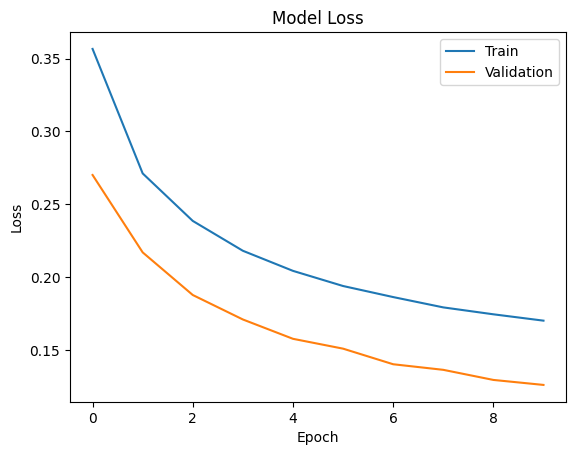

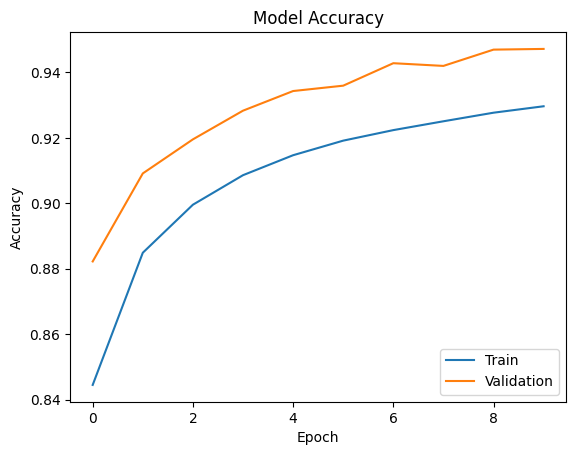

In [18]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert annotations to one-hot encoding
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, stratify=y, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
n_timesteps=1
n_features = X_train.shape[1]  # Number of features in your data
X_train_reshaped = X_train.reshape(X_train.shape[0], n_timesteps, n_features)
X_test_reshaped = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

# Initialize the LSTM model
# Define the architecture
model = Sequential()

# Input layer
model.add(LSTM(128, input_shape=(n_timesteps, n_features), activation='relu', return_sequences=True))
model.add(Dropout(0.2))  # Adding dropout for regularization

# Hidden layer
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization

# Output layer
model.add(Dense(4, activation='softmax'))  # Assuming 3 classes (0, 1, 2,3)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history=model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.3,callbacks=[early_stopping])


# Assuming you've already trained the model and have the 'history' object

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()



In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)

17981/17981 [==============================] - 41s 2ms/step - loss: 0.0947 - accuracy: 0.9598
Accuracy: 0.9598045945167542


In [19]:
# Assuming you've trained and compiled the 'model' already

# Save the model
model.save('lstm_model_onset_offset.h5')

In [20]:
from google.colab import files

# Upload the saved model file
uploaded = files.upload()

Saving lstm_model_onset_offset.h5 to lstm_model_onset_offset (1).h5


In [21]:
import shutil

# Move the uploaded file to Google Drive
shutil.move(list(uploaded.keys())[0], '/content/drive/MyDrive/lstm_model_onset_offset.h5')

'/content/drive/MyDrive/lstm_model_onset_offset.h5'

In [3]:
from keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/MyDrive/lstm_model_onset_offset.h5')

# Now you can use 'loaded_model' for making predictions